In [1]:
path = './dataset/'

In [2]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

class CardsDataset(Dataset):
    def __init__(self, directory, split='train', transforms=None):
        super().__init__()

        self.transforms = transforms
        self.images = []
        self.classes = set()
        
        for root, dirs, files in os.walk(os.path.join(directory, split)):
            for filename in files:
                if filename.lower().endswith(('.png', 'jpeg', 'jpg')):
                    label = os.path.basename(root)
                    self.classes.add(label)
                    self.images.append((os.path.join(root, filename), label))
                    
        self.cls2idx = {cls: i for i, cls in enumerate(sorted(self.classes))}
        self.idx2cls = {i: cls for cls, i in self.cls2idx.items()}
        self.length = len(self.images)

        if self.length == 0:
            raise RuntimeError(f"No images found in {os.path.join(directory, split)}")

    def __getitem__(self, idx):
        image_path, label = self.images[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transforms:
            image = self.transforms(image)

        label_idx = self.cls2idx[label]
        return image, label_idx

    def __len__(self):
        return self.length

    def idx_2_cls(self, idx):
        return self.idx2cls[idx]

In [3]:
import torch
from torchvision.transforms import v2

temp_transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
])

train_dataset_temp = CardsDataset('./dataset/', split='train', transforms=temp_transforms)
train_loader_temp = DataLoader(train_dataset_temp, batch_size=64, num_workers=12)

mean = 0.0
std = 0.0
total_images = 0

for images, _ in train_loader_temp:
    batch_samples = images.size(0)  
    
    images = images.view(batch_samples, images.size(1), -1) 
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    total_images += batch_samples

mean /= total_images
std /= total_images

In [4]:
mean, std

(tensor([0.7786, 0.7310, 0.7050]), tensor([0.2236, 0.2728, 0.2727]))

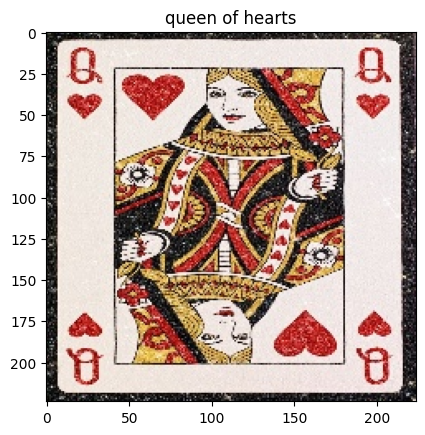

In [5]:
import matplotlib.pyplot as plt

img, idx = train_dataset_temp[0]
cls = train_dataset_temp.idx_2_cls(idx)

plt.imshow(img.permute(1, 2, 0))
plt.title(cls);

In [6]:
from torchvision.transforms import v2

transforms = v2.Compose([
    v2.RandomResizedCrop((224, 224), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(degrees=(-15, 15)),
    v2.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.15),
    v2.Resize((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=mean, std=std)
])

In [7]:
def denormalize(img, mean, std):
    mean = mean.detach().clone().view(-1, 1, 1)
    std = std.detach().clone().view(-1, 1, 1)
    return img * std + mean

In [8]:
train_dataset = CardsDataset('./dataset/', 'train', transforms=transforms)
val_dataset = CardsDataset('./dataset/', 'val', transforms=transforms)
test_dataset = CardsDataset('./dataset/', 'test', transforms=transforms)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, drop_last=False)

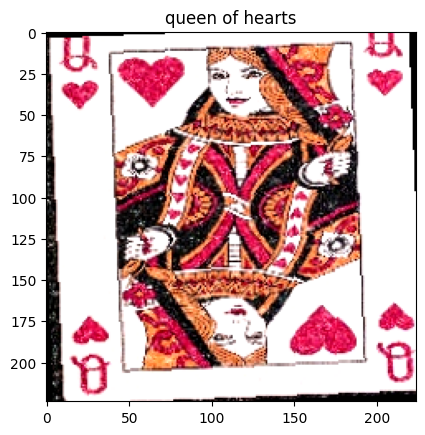

In [9]:
import matplotlib.pyplot as plt

img, idx = train_dataset[0]
denormalized_img = denormalize(img, mean, std)

cls = train_dataset.idx_2_cls(idx)

plt.imshow(denormalized_img.permute(1, 2, 0))
plt.title(cls);

In [10]:
import torch
import torch.nn as nn

class AeBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, bottleneck_ratio=4):
        super().__init__()
        bottleneck_channels = out_channels // bottleneck_ratio  

        self.block = nn.Sequential(
            nn.Conv2d(in_channels, bottleneck_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(bottleneck_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(bottleneck_channels, bottleneck_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(bottleneck_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(bottleneck_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.block(x) + self.shortcut(x))


class AeNet(nn.Module):
    def __init__(self, n_classes):
        super().__init__()

        self.initial = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),  # 224 → 112
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # 112 → 56
        )

        self.features = nn.Sequential(
            AeBlock(64, 128, stride=2),   # 56 → 28
            AeBlock(128, 256, stride=2),  # 28 → 14
            AeBlock(256, 512, stride=2)   # 14 → 7
        )

        self.classificator = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(512, n_classes)
        )

    def forward(self, x):
        x = self.initial(x)
        x = self.features(x)
        x = self.classificator(x)
        return x

In [11]:
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from torch.optim.lr_scheduler import CosineAnnealingLR

device = 'cuda' if torch.cuda.is_available() else 'cpu'

n_classes = len(train_dataset.cls2idx)
model = AeNet(n_classes=n_classes).to(device)
optimizer = AdamW(params=model.parameters(), lr=1e-4, weight_decay=0.01)
loss_func = CrossEntropyLoss()
scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)
epochs = 50

In [12]:
import os
os.makedirs('./checkpoints/model/', exist_ok=True)

In [13]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
import torch

train_loss, val_loss = [], []
train_accuracy, val_accuracy = [], []
train_f1_model, val_f1_model = [], []

best_val_accuracy = 0.0

for e in range(epochs):
    tqdm_loader = tqdm(train_loader, desc=f'Epoch {e+1}/{epochs}', unit='batch')
    model.train()

    Q_train_total = 0
    count_train = 0
    all_preds_train, all_labels_train = [], []

    for x_train, y_train in tqdm_loader:
        x_train, y_train = x_train.to(device), y_train.to(device)
        
        y_pred = model(x_train)
        loss = loss_func(y_pred, y_train)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        count_train += 1
        Q_train_total += loss.item()
        Q_train = Q_train_total / count_train

        _, predicted = torch.max(y_pred, dim=1)
        all_preds_train.extend(predicted.cpu().numpy())
        all_labels_train.extend(y_train.cpu().numpy())

        tqdm_loader.set_postfix(loss=Q_train)

    train_loss.append(Q_train)
    accuracy_train = accuracy_score(all_labels_train, all_preds_train)
    f1_train = f1_score(all_labels_train, all_preds_train, average='weighted')
    train_accuracy.append(accuracy_train)
    train_f1_model.append(f1_train)

    model.eval()
    Q_val_total, count_val = 0, 0
    all_preds_val, all_labels_val = [], []

    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            
            y_pred = model(x_val)
            loss = loss_func(y_pred, y_val)

            count_val += 1
            Q_val_total += loss.item()

            _, predicted = torch.max(y_pred, dim=1)
            all_preds_val.extend(predicted.cpu().numpy())
            all_labels_val.extend(y_val.cpu().numpy())

    Q_val = Q_val_total / count_val
    val_loss.append(Q_val)
    accuracy_val = accuracy_score(all_labels_val, all_preds_val)
    f1_val = f1_score(all_labels_val, all_preds_val, average='weighted')
    val_accuracy.append(accuracy_val)
    val_f1_model.append(f1_val)

    if accuracy_val > best_val_accuracy:
        best_val_accuracy = accuracy_val
        torch.save({
            'epoch': e,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_loss': Q_val,
            'val_accuracy': accuracy_val,
            'val_f1': f1_val
        }, './checkpoints/model/' + f'best_checkpoint_{e}_epoch.pth')
        print(f"New best model saved with val accuracy: {best_val_accuracy:.4f}, F1: {f1_val:.4f}")

    scheduler.step()

    print(f"Current LR: {scheduler.optimizer.param_groups[0]['lr']}")
    print(f"Epoch {e+1}/{epochs} -> Train Loss: {Q_train:.4f}, Acc: {accuracy_train:.4f}, F1: {f1_train:.4f}")
    print(f"Epoch {e+1}/{epochs} -> Val Loss: {Q_val:.4f}, Acc: {accuracy_val:.4f}, F1: {f1_val:.4f}")

Epoch 1/70: 100%|███████████████| 476/476 [00:24<00:00, 19.15batch/s, loss=3.58]


New best model saved with val accuracy: 0.0981, F1: 0.0440
Current LR: 9.990232305719945e-05
Epoch 1/70 -> Train Loss: 3.5777, Acc: 0.0705, F1: 0.0566
Epoch 1/70 -> Val Loss: 3.1046, Acc: 0.0981, F1: 0.0440


Epoch 2/70: 100%|███████████████| 476/476 [00:27<00:00, 17.49batch/s, loss=3.16]


New best model saved with val accuracy: 0.1321, F1: 0.0802
Current LR: 9.960967771506666e-05
Epoch 2/70 -> Train Loss: 3.1627, Acc: 0.1141, F1: 0.0909
Epoch 2/70 -> Val Loss: 2.9767, Acc: 0.1321, F1: 0.0802


Epoch 3/70: 100%|███████████████| 476/476 [00:27<00:00, 17.41batch/s, loss=3.01]


Current LR: 9.912321891107009e-05
Epoch 3/70 -> Train Loss: 3.0141, Acc: 0.1438, F1: 0.1237
Epoch 3/70 -> Val Loss: 2.7815, Acc: 0.1283, F1: 0.0877


Epoch 4/70: 100%|████████████████| 476/476 [00:27<00:00, 17.46batch/s, loss=2.9]


New best model saved with val accuracy: 0.1698, F1: 0.1311
Current LR: 9.844486647586723e-05
Epoch 4/70 -> Train Loss: 2.9013, Acc: 0.1632, F1: 0.1449
Epoch 4/70 -> Val Loss: 2.6762, Acc: 0.1698, F1: 0.1311


Epoch 5/70: 100%|███████████████| 476/476 [00:26<00:00, 17.70batch/s, loss=2.81]


Current LR: 9.757729755661011e-05
Epoch 5/70 -> Train Loss: 2.8134, Acc: 0.1967, F1: 0.1784
Epoch 5/70 -> Val Loss: 2.5885, Acc: 0.1585, F1: 0.1162


Epoch 6/70: 100%|███████████████| 476/476 [00:26<00:00, 18.01batch/s, loss=2.71]


New best model saved with val accuracy: 0.2642, F1: 0.2078
Current LR: 9.652393605146844e-05
Epoch 6/70 -> Train Loss: 2.7064, Acc: 0.2218, F1: 0.2021
Epoch 6/70 -> Val Loss: 2.4571, Acc: 0.2642, F1: 0.2078


Epoch 7/70: 100%|███████████████| 476/476 [00:25<00:00, 18.37batch/s, loss=2.62]


Current LR: 9.528893909706797e-05
Epoch 7/70 -> Train Loss: 2.6224, Acc: 0.2525, F1: 0.2384
Epoch 7/70 -> Val Loss: 2.3925, Acc: 0.2264, F1: 0.1932


Epoch 8/70: 100%|███████████████| 476/476 [00:25<00:00, 18.32batch/s, loss=2.53]


New best model saved with val accuracy: 0.2868, F1: 0.2296
Current LR: 9.387718066217124e-05
Epoch 8/70 -> Train Loss: 2.5277, Acc: 0.2847, F1: 0.2697
Epoch 8/70 -> Val Loss: 2.2333, Acc: 0.2868, F1: 0.2296


Epoch 9/70: 100%|███████████████| 476/476 [00:26<00:00, 18.23batch/s, loss=2.45]


New best model saved with val accuracy: 0.3057, F1: 0.2623
Current LR: 9.229423231234974e-05
Epoch 9/70 -> Train Loss: 2.4503, Acc: 0.3078, F1: 0.2937
Epoch 9/70 -> Val Loss: 2.1924, Acc: 0.3057, F1: 0.2623


Epoch 10/70: 100%|██████████████| 476/476 [00:26<00:00, 18.28batch/s, loss=2.37]


New best model saved with val accuracy: 0.3509, F1: 0.2940
Current LR: 9.054634122155989e-05
Epoch 10/70 -> Train Loss: 2.3749, Acc: 0.3254, F1: 0.3136
Epoch 10/70 -> Val Loss: 2.0885, Acc: 0.3509, F1: 0.2940


Epoch 11/70: 100%|██████████████| 476/476 [00:26<00:00, 18.16batch/s, loss=2.32]


New best model saved with val accuracy: 0.3925, F1: 0.3627
Current LR: 8.864040551740155e-05
Epoch 11/70 -> Train Loss: 2.3176, Acc: 0.3504, F1: 0.3388
Epoch 11/70 -> Val Loss: 2.1084, Acc: 0.3925, F1: 0.3627


Epoch 12/70: 100%|██████████████| 476/476 [00:25<00:00, 18.36batch/s, loss=2.25]


Current LR: 8.658394705735986e-05
Epoch 12/70 -> Train Loss: 2.2464, Acc: 0.3771, F1: 0.3678
Epoch 12/70 -> Val Loss: 1.9525, Acc: 0.3811, F1: 0.3330


Epoch 13/70: 100%|██████████████| 476/476 [00:25<00:00, 18.42batch/s, loss=2.19]


Current LR: 8.438508174347008e-05
Epoch 13/70 -> Train Loss: 2.1902, Acc: 0.3839, F1: 0.3754
Epoch 13/70 -> Val Loss: 1.9233, Acc: 0.3887, F1: 0.3431


Epoch 14/70: 100%|██████████████| 476/476 [00:25<00:00, 18.47batch/s, loss=2.13]


New best model saved with val accuracy: 0.4302, F1: 0.3900
Current LR: 8.205248749256013e-05
Epoch 14/70 -> Train Loss: 2.1297, Acc: 0.4122, F1: 0.4051
Epoch 14/70 -> Val Loss: 1.8665, Acc: 0.4302, F1: 0.3900


Epoch 15/70: 100%|██████████████| 476/476 [00:25<00:00, 18.31batch/s, loss=2.08]


New best model saved with val accuracy: 0.4415, F1: 0.4176
Current LR: 7.959536998847742e-05
Epoch 15/70 -> Train Loss: 2.0751, Acc: 0.4227, F1: 0.4144
Epoch 15/70 -> Val Loss: 1.8376, Acc: 0.4415, F1: 0.4176


Epoch 16/70: 100%|██████████████| 476/476 [00:26<00:00, 18.26batch/s, loss=2.03]


New best model saved with val accuracy: 0.4642, F1: 0.4295
Current LR: 7.702342635146032e-05
Epoch 16/70 -> Train Loss: 2.0337, Acc: 0.4378, F1: 0.4321
Epoch 16/70 -> Val Loss: 1.7752, Acc: 0.4642, F1: 0.4295


Epoch 17/70: 100%|██████████████| 476/476 [00:25<00:00, 18.49batch/s, loss=1.99]


Current LR: 7.434680686803489e-05
Epoch 17/70 -> Train Loss: 1.9901, Acc: 0.4515, F1: 0.4445
Epoch 17/70 -> Val Loss: 1.7649, Acc: 0.4604, F1: 0.4284


Epoch 18/70: 100%|██████████████| 476/476 [00:26<00:00, 18.18batch/s, loss=1.93]


New best model saved with val accuracy: 0.4868, F1: 0.4654
Current LR: 7.157607493247108e-05
Epoch 18/70 -> Train Loss: 1.9308, Acc: 0.4676, F1: 0.4626
Epoch 18/70 -> Val Loss: 1.7427, Acc: 0.4868, F1: 0.4654


Epoch 19/70: 100%|███████████████| 476/476 [00:25<00:00, 18.41batch/s, loss=1.9]


New best model saved with val accuracy: 0.5019, F1: 0.4798
Current LR: 6.872216535789155e-05
Epoch 19/70 -> Train Loss: 1.9018, Acc: 0.4786, F1: 0.4726
Epoch 19/70 -> Val Loss: 1.7031, Acc: 0.5019, F1: 0.4798


Epoch 20/70: 100%|██████████████| 476/476 [00:25<00:00, 18.38batch/s, loss=1.87]


Current LR: 6.579634122155988e-05
Epoch 20/70 -> Train Loss: 1.8678, Acc: 0.4873, F1: 0.4821
Epoch 20/70 -> Val Loss: 1.6578, Acc: 0.4679, F1: 0.4397


Epoch 21/70: 100%|██████████████| 476/476 [00:25<00:00, 18.32batch/s, loss=1.83]


Current LR: 6.28101494146603e-05
Epoch 21/70 -> Train Loss: 1.8332, Acc: 0.4953, F1: 0.4913
Epoch 21/70 -> Val Loss: 1.5964, Acc: 0.4981, F1: 0.4748


Epoch 22/70: 100%|███████████████| 476/476 [00:26<00:00, 18.17batch/s, loss=1.8]


Current LR: 5.9775375071993364e-05
Epoch 22/70 -> Train Loss: 1.8006, Acc: 0.5053, F1: 0.5006
Epoch 22/70 -> Val Loss: 1.5838, Acc: 0.4717, F1: 0.4430


Epoch 23/70: 100%|██████████████| 476/476 [00:26<00:00, 18.30batch/s, loss=1.78]


New best model saved with val accuracy: 0.5170, F1: 0.4937
Current LR: 5.670399506143306e-05
Epoch 23/70 -> Train Loss: 1.7759, Acc: 0.5127, F1: 0.5093
Epoch 23/70 -> Val Loss: 1.5966, Acc: 0.5170, F1: 0.4937


Epoch 24/70: 100%|██████████████| 476/476 [00:25<00:00, 18.32batch/s, loss=1.74]


New best model saved with val accuracy: 0.5698, F1: 0.5469
Current LR: 5.3608130716701005e-05
Epoch 24/70 -> Train Loss: 1.7394, Acc: 0.5255, F1: 0.5218
Epoch 24/70 -> Val Loss: 1.5407, Acc: 0.5698, F1: 0.5469


Epoch 25/70: 100%|██████████████| 476/476 [00:26<00:00, 18.23batch/s, loss=1.73]


Current LR: 5.049999999999999e-05
Epoch 25/70 -> Train Loss: 1.7251, Acc: 0.5260, F1: 0.5223
Epoch 25/70 -> Val Loss: 1.5335, Acc: 0.5358, F1: 0.5149


Epoch 26/70: 100%|██████████████| 476/476 [00:26<00:00, 17.95batch/s, loss=1.69]


New best model saved with val accuracy: 0.5811, F1: 0.5739
Current LR: 4.7391869283298976e-05
Epoch 26/70 -> Train Loss: 1.6945, Acc: 0.5369, F1: 0.5327
Epoch 26/70 -> Val Loss: 1.4795, Acc: 0.5811, F1: 0.5739


Epoch 27/70: 100%|██████████████| 476/476 [00:26<00:00, 18.19batch/s, loss=1.68]


Current LR: 4.429600493856693e-05
Epoch 27/70 -> Train Loss: 1.6776, Acc: 0.5471, F1: 0.5439
Epoch 27/70 -> Val Loss: 1.4796, Acc: 0.5434, F1: 0.5251


Epoch 28/70: 100%|██████████████| 476/476 [00:25<00:00, 18.65batch/s, loss=1.65]


Current LR: 4.122462492800662e-05
Epoch 28/70 -> Train Loss: 1.6539, Acc: 0.5477, F1: 0.5442
Epoch 28/70 -> Val Loss: 1.4278, Acc: 0.5660, F1: 0.5336


Epoch 29/70: 100%|██████████████| 476/476 [00:25<00:00, 18.61batch/s, loss=1.63]


Current LR: 3.8189850585339674e-05
Epoch 29/70 -> Train Loss: 1.6344, Acc: 0.5507, F1: 0.5479
Epoch 29/70 -> Val Loss: 1.4168, Acc: 0.5472, F1: 0.5320


Epoch 30/70: 100%|██████████████| 476/476 [00:25<00:00, 18.37batch/s, loss=1.61]


Current LR: 3.5203658778440106e-05
Epoch 30/70 -> Train Loss: 1.6150, Acc: 0.5638, F1: 0.5600
Epoch 30/70 -> Val Loss: 1.3908, Acc: 0.5623, F1: 0.5464


Epoch 31/70: 100%|███████████████| 476/476 [00:25<00:00, 18.51batch/s, loss=1.6]


Current LR: 3.227783464210844e-05
Epoch 31/70 -> Train Loss: 1.6025, Acc: 0.5660, F1: 0.5631
Epoch 31/70 -> Val Loss: 1.4164, Acc: 0.5660, F1: 0.5596


Epoch 32/70: 100%|██████████████| 476/476 [00:25<00:00, 18.48batch/s, loss=1.58]


New best model saved with val accuracy: 0.5887, F1: 0.5845
Current LR: 2.942392506752889e-05
Epoch 32/70 -> Train Loss: 1.5849, Acc: 0.5763, F1: 0.5728
Epoch 32/70 -> Val Loss: 1.4040, Acc: 0.5887, F1: 0.5845


Epoch 33/70: 100%|██████████████| 476/476 [00:25<00:00, 18.40batch/s, loss=1.58]


Current LR: 2.6653193131965075e-05
Epoch 33/70 -> Train Loss: 1.5753, Acc: 0.5771, F1: 0.5738
Epoch 33/70 -> Val Loss: 1.3859, Acc: 0.5887, F1: 0.5797


Epoch 34/70: 100%|██████████████| 476/476 [00:25<00:00, 18.53batch/s, loss=1.57]


Current LR: 2.3976573648539646e-05
Epoch 34/70 -> Train Loss: 1.5716, Acc: 0.5772, F1: 0.5739
Epoch 34/70 -> Val Loss: 1.3822, Acc: 0.5887, F1: 0.5704


Epoch 35/70: 100%|██████████████| 476/476 [00:25<00:00, 18.45batch/s, loss=1.54]


New best model saved with val accuracy: 0.6075, F1: 0.6034
Current LR: 2.1404630011522576e-05
Epoch 35/70 -> Train Loss: 1.5408, Acc: 0.5863, F1: 0.5829
Epoch 35/70 -> Val Loss: 1.3588, Acc: 0.6075, F1: 0.6034


Epoch 36/70: 100%|██████████████| 476/476 [00:25<00:00, 18.37batch/s, loss=1.53]


New best model saved with val accuracy: 0.6151, F1: 0.6055
Current LR: 1.8947512507439848e-05
Epoch 36/70 -> Train Loss: 1.5263, Acc: 0.5948, F1: 0.5905
Epoch 36/70 -> Val Loss: 1.3496, Acc: 0.6151, F1: 0.6055


Epoch 37/70: 100%|██████████████| 476/476 [00:26<00:00, 17.90batch/s, loss=1.53]


Current LR: 1.66149182565299e-05
Epoch 37/70 -> Train Loss: 1.5304, Acc: 0.5894, F1: 0.5860
Epoch 37/70 -> Val Loss: 1.4305, Acc: 0.5774, F1: 0.5663


Epoch 38/70: 100%|██████████████| 476/476 [00:26<00:00, 17.92batch/s, loss=1.52]


New best model saved with val accuracy: 0.6340, F1: 0.6336
Current LR: 1.4416052942640132e-05
Epoch 38/70 -> Train Loss: 1.5168, Acc: 0.5936, F1: 0.5911
Epoch 38/70 -> Val Loss: 1.2872, Acc: 0.6340, F1: 0.6336


Epoch 39/70: 100%|██████████████| 476/476 [00:26<00:00, 18.17batch/s, loss=1.51]


Current LR: 1.235959448259843e-05
Epoch 39/70 -> Train Loss: 1.5102, Acc: 0.5951, F1: 0.5916
Epoch 39/70 -> Val Loss: 1.3318, Acc: 0.6075, F1: 0.5972


Epoch 40/70: 100%|███████████████| 476/476 [00:25<00:00, 18.43batch/s, loss=1.5]


Current LR: 1.04536587784401e-05
Epoch 40/70 -> Train Loss: 1.4979, Acc: 0.5982, F1: 0.5959
Epoch 40/70 -> Val Loss: 1.2932, Acc: 0.6302, F1: 0.6202


Epoch 41/70: 100%|██████████████| 476/476 [00:25<00:00, 18.37batch/s, loss=1.48]


Current LR: 8.70576768765026e-06
Epoch 41/70 -> Train Loss: 1.4837, Acc: 0.6015, F1: 0.5988
Epoch 41/70 -> Val Loss: 1.3351, Acc: 0.6151, F1: 0.6109


Epoch 42/70: 100%|██████████████| 476/476 [00:25<00:00, 18.31batch/s, loss=1.49]


Current LR: 7.122819337828748e-06
Epoch 42/70 -> Train Loss: 1.4865, Acc: 0.5991, F1: 0.5962
Epoch 42/70 -> Val Loss: 1.3338, Acc: 0.6151, F1: 0.6053


Epoch 43/70: 100%|██████████████| 476/476 [00:26<00:00, 18.20batch/s, loss=1.48]


Current LR: 5.711060902932039e-06
Epoch 43/70 -> Train Loss: 1.4767, Acc: 0.5997, F1: 0.5971
Epoch 43/70 -> Val Loss: 1.3200, Acc: 0.6264, F1: 0.6261


Epoch 44/70: 100%|██████████████| 476/476 [00:26<00:00, 18.29batch/s, loss=1.47]


Current LR: 4.476063948531556e-06
Epoch 44/70 -> Train Loss: 1.4739, Acc: 0.6082, F1: 0.6060
Epoch 44/70 -> Val Loss: 1.3707, Acc: 0.6113, F1: 0.6044


Epoch 45/70: 100%|██████████████| 476/476 [00:26<00:00, 18.17batch/s, loss=1.47]


Current LR: 3.4227024433898985e-06
Epoch 45/70 -> Train Loss: 1.4651, Acc: 0.6057, F1: 0.6041
Epoch 45/70 -> Val Loss: 1.3335, Acc: 0.5887, F1: 0.5822


Epoch 46/70: 100%|██████████████| 476/476 [00:25<00:00, 18.42batch/s, loss=1.46]


New best model saved with val accuracy: 0.6377, F1: 0.6356
Current LR: 2.555133524132766e-06
Epoch 46/70 -> Train Loss: 1.4643, Acc: 0.6077, F1: 0.6050
Epoch 46/70 -> Val Loss: 1.2730, Acc: 0.6377, F1: 0.6356


Epoch 47/70: 100%|██████████████| 476/476 [00:26<00:00, 18.20batch/s, loss=1.47]


Current LR: 1.8767810889299075e-06
Epoch 47/70 -> Train Loss: 1.4718, Acc: 0.6048, F1: 0.6019
Epoch 47/70 -> Val Loss: 1.3114, Acc: 0.6264, F1: 0.6231


Epoch 48/70: 100%|██████████████| 476/476 [00:26<00:00, 18.18batch/s, loss=1.46]


Current LR: 1.3903222849333503e-06
Epoch 48/70 -> Train Loss: 1.4615, Acc: 0.6044, F1: 0.6022
Epoch 48/70 -> Val Loss: 1.3437, Acc: 0.5887, F1: 0.5846


Epoch 49/70: 100%|██████████████| 476/476 [00:26<00:00, 18.02batch/s, loss=1.46]


Current LR: 1.0976769428005576e-06
Epoch 49/70 -> Train Loss: 1.4590, Acc: 0.6041, F1: 0.6018
Epoch 49/70 -> Val Loss: 1.2881, Acc: 0.6075, F1: 0.5986


Epoch 50/70: 100%|██████████████| 476/476 [00:26<00:00, 18.11batch/s, loss=1.46]


Current LR: 1e-06
Epoch 50/70 -> Train Loss: 1.4622, Acc: 0.6088, F1: 0.6064
Epoch 50/70 -> Val Loss: 1.3513, Acc: 0.5962, F1: 0.5902


Epoch 51/70: 100%|██████████████| 476/476 [00:26<00:00, 18.16batch/s, loss=1.47]


Current LR: 1.0976769428005578e-06
Epoch 51/70 -> Train Loss: 1.4676, Acc: 0.6069, F1: 0.6047
Epoch 51/70 -> Val Loss: 1.2782, Acc: 0.6302, F1: 0.6191


Epoch 52/70: 100%|██████████████| 476/476 [00:26<00:00, 18.12batch/s, loss=1.46]


Current LR: 1.3903222849333452e-06
Epoch 52/70 -> Train Loss: 1.4619, Acc: 0.6154, F1: 0.6129
Epoch 52/70 -> Val Loss: 1.3210, Acc: 0.5925, F1: 0.5851


Epoch 53/70: 100%|██████████████| 476/476 [00:26<00:00, 18.02batch/s, loss=1.47]


New best model saved with val accuracy: 0.6415, F1: 0.6411
Current LR: 1.8767810889299138e-06
Epoch 53/70 -> Train Loss: 1.4674, Acc: 0.6090, F1: 0.6057
Epoch 53/70 -> Val Loss: 1.3759, Acc: 0.6415, F1: 0.6411


Epoch 54/70: 100%|██████████████| 476/476 [00:26<00:00, 18.09batch/s, loss=1.46]


Current LR: 2.5551335241327563e-06
Epoch 54/70 -> Train Loss: 1.4632, Acc: 0.6040, F1: 0.6013
Epoch 54/70 -> Val Loss: 1.3110, Acc: 0.6264, F1: 0.6220


Epoch 55/70: 100%|██████████████| 476/476 [00:25<00:00, 18.55batch/s, loss=1.47]


Current LR: 3.4227024433898943e-06
Epoch 55/70 -> Train Loss: 1.4710, Acc: 0.6053, F1: 0.6030
Epoch 55/70 -> Val Loss: 1.3375, Acc: 0.5849, F1: 0.5733


Epoch 56/70: 100%|██████████████| 476/476 [00:26<00:00, 18.27batch/s, loss=1.47]


Current LR: 4.4760639485315525e-06
Epoch 56/70 -> Train Loss: 1.4714, Acc: 0.6088, F1: 0.6064
Epoch 56/70 -> Val Loss: 1.3271, Acc: 0.6075, F1: 0.6020


Epoch 57/70: 100%|██████████████| 476/476 [00:26<00:00, 18.30batch/s, loss=1.46]


Current LR: 5.711060902932025e-06
Epoch 57/70 -> Train Loss: 1.4642, Acc: 0.6108, F1: 0.6083
Epoch 57/70 -> Val Loss: 1.3748, Acc: 0.5887, F1: 0.5888


Epoch 58/70: 100%|██████████████| 476/476 [00:26<00:00, 18.25batch/s, loss=1.47]


New best model saved with val accuracy: 0.6453, F1: 0.6408
Current LR: 7.122819337828757e-06
Epoch 58/70 -> Train Loss: 1.4667, Acc: 0.6110, F1: 0.6088
Epoch 58/70 -> Val Loss: 1.2705, Acc: 0.6453, F1: 0.6408


Epoch 59/70: 100%|██████████████| 476/476 [00:26<00:00, 17.94batch/s, loss=1.46]


Current LR: 8.70576768765025e-06
Epoch 59/70 -> Train Loss: 1.4591, Acc: 0.6123, F1: 0.6096
Epoch 59/70 -> Val Loss: 1.3215, Acc: 0.6000, F1: 0.5934


Epoch 60/70:  29%|████          | 140/476 [00:07<00:19, 17.56batch/s, loss=1.45]


KeyboardInterrupt: 

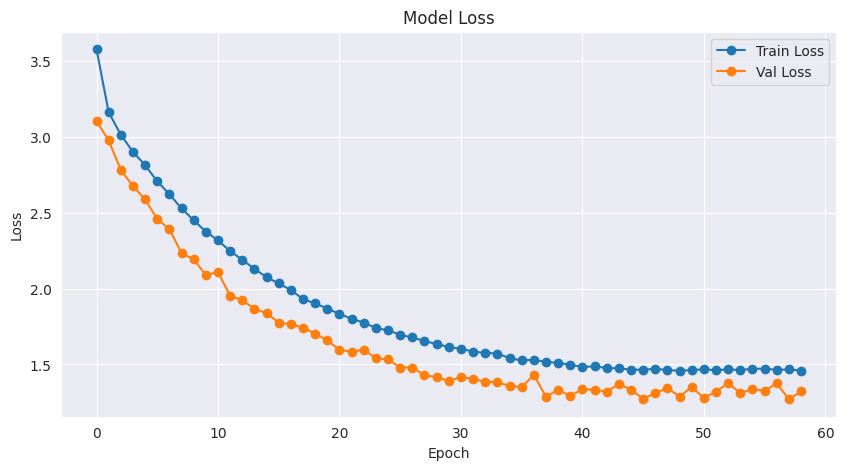

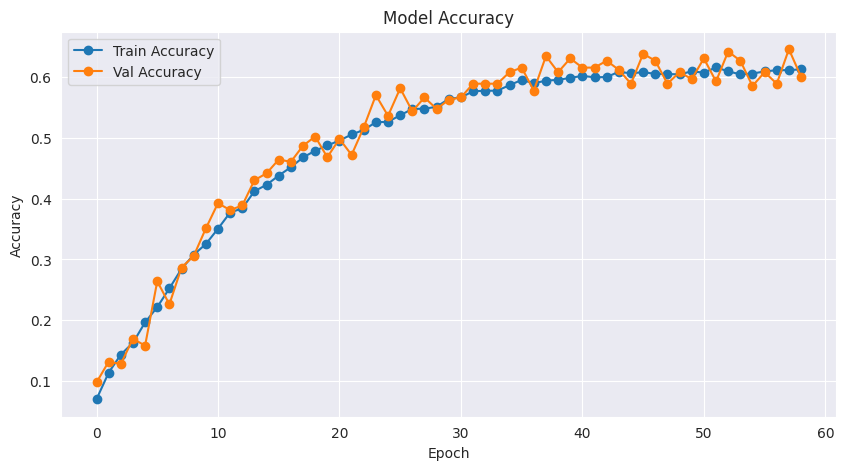

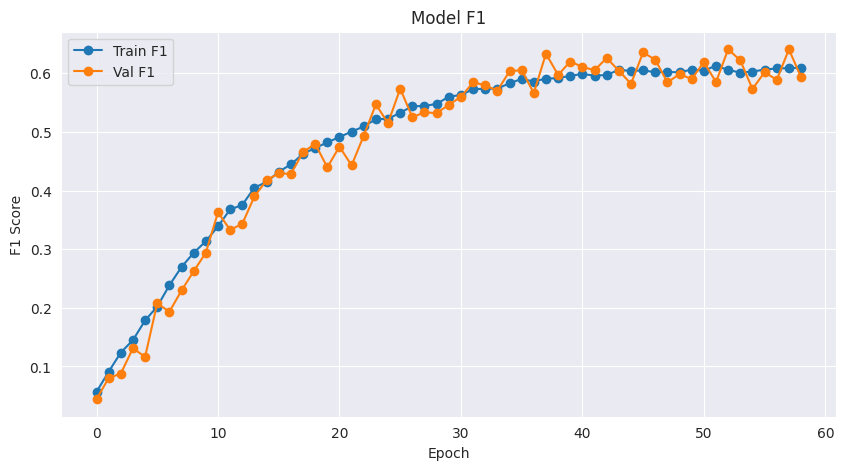

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

plt.figure(figsize=(10,5))
plt.plot(train_loss, label='Train Loss', marker='o')
plt.plot(val_loss, label='Val Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True);

plt.figure(figsize=(10,5))
plt.plot(train_accuracy, label='Train Accuracy', marker='o')
plt.plot(val_accuracy, label='Val Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True);

plt.figure(figsize=(10,5))
plt.plot(train_f1_model, label='Train F1', marker='o')
plt.plot(val_f1_model, label='Val F1', marker='o')
plt.title('Model F1')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True);

In [25]:
from torchvision import models

resnet = models.resnet50(pretrained=True)

for param in resnet.parameters():
    param.requires_grad = False
    
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 53)

for param in resnet.fc.parameters():
    param.requires_grad = True

resnet = resnet.to(device)

resnet_optimizer = AdamW(params=resnet.fc.parameters(), lr=1e-4, weight_decay=0.01)
loss_func = CrossEntropyLoss()
resnet_scheduler = CosineAnnealingLR(resnet_optimizer, T_max=50, eta_min=1e-6)
epochs = 30

In [26]:
import os
os.makedirs('./checkpoints/resnet/', exist_ok=True)

In [27]:
train_loss, val_loss = [], []
train_accuracy, val_accuracy = [], []
train_f1_resnet, val_f1_resnet = [], []

best_val_accuracy = 0.0

for e in range(epochs):
    tqdm_loader = tqdm(train_loader, desc=f'Epoch {e+1}/{epochs}', unit='batch')
    resnet.train()

    total_train_loss = 0
    all_preds_train, all_labels_train = [], []

    if e == 10:
        print('Start classifier finetuning')
        for param in resnet.layer4.parameters():
            param.requires_grad = True

        resnet_optimizer = AdamW(
        params=[p for p in resnet.parameters() if p.requires_grad],
        lr=5e-5,           
        weight_decay=0.01)
        
        resnet_scheduler = CosineAnnealingLR(resnet_optimizer, T_max=50, eta_min=1e-6)

        


    for x_train, y_train in tqdm_loader:
        x_train, y_train = x_train.to(device), y_train.to(device)
        
        y_pred = resnet(x_train)
        loss = loss_func(y_pred, y_train)
        
        resnet_optimizer.zero_grad()
        loss.backward()
        resnet_optimizer.step()

        total_train_loss += loss.item()

        _, predicted = torch.max(y_pred, dim=1)
        all_preds_train.extend(predicted.cpu().numpy())
        all_labels_train.extend(y_train.cpu().numpy())

        tqdm_loader.set_postfix(loss=total_train_loss / len(all_preds_train))

    epoch_train_loss = total_train_loss / len(train_loader)
    accuracy_train = accuracy_score(all_labels_train, all_preds_train)
    f1_train = f1_score(all_labels_train, all_preds_train, average='weighted')

    train_loss.append(epoch_train_loss)
    train_accuracy.append(accuracy_train)
    train_f1_resnet.append(f1_train)

    resnet.eval()
    total_val_loss = 0
    all_preds_val, all_labels_val = [], []

    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)

            y_pred = resnet(x_val)
            loss = loss_func(y_pred, y_val)

            total_val_loss += loss.item()

            _, predicted = torch.max(y_pred, dim=1)
            all_preds_val.extend(predicted.cpu().numpy())
            all_labels_val.extend(y_val.cpu().numpy())

    epoch_val_loss = total_val_loss / len(val_loader)
    accuracy_val = accuracy_score(all_labels_val, all_preds_val)
    f1_val = f1_score(all_labels_val, all_preds_val, average='weighted')

    val_loss.append(epoch_val_loss)
    val_accuracy.append(accuracy_val)
    val_f1_resnet.append(f1_val)

    if accuracy_val > best_val_accuracy:
        best_val_accuracy = accuracy_val
        torch.save({
            'epoch': e,
            'model_state_dict': resnet.state_dict(),
            'optimizer_state_dict': resnet_optimizer.state_dict(),
            'scheduler_state_dict': resnet_scheduler.state_dict(),
            'val_loss': epoch_val_loss,
            'val_accuracy': accuracy_val,
            'val_f1': f1_val
        }, './checkpoints/resnet/' + f'best_checkpoint_{e}_epoch.pth')
        print(f"New best model saved with val accuracy: {best_val_accuracy:.4f}, F1: {f1_val:.4f}")

    resnet_scheduler.step()

    print(f"Current LR: {resnet_scheduler.optimizer.param_groups[0]['lr']:.6f}")
    print(f"Epoch {e+1}/{epochs} -> Train Loss: {epoch_train_loss:.4f}, Acc: {accuracy_train:.4f}, F1: {f1_train:.4f}")
    print(f"Epoch {e+1}/{epochs} -> Val Loss: {epoch_val_loss:.4f}, Acc: {accuracy_val:.4f}, F1: {f1_val:.4f}")

Epoch 1/50: 100%|██████████████| 476/476 [00:34<00:00, 13.91batch/s, loss=0.226]


New best model saved with val accuracy: 0.2113, F1: 0.1568
Current LR: 0.000100
Epoch 1/50 -> Train Loss: 3.6193, Acc: 0.1073, F1: 0.0949
Epoch 1/50 -> Val Loss: 3.1501, Acc: 0.2113, F1: 0.1568


Epoch 2/50: 100%|██████████████| 476/476 [00:34<00:00, 13.96batch/s, loss=0.195]


New best model saved with val accuracy: 0.2491, F1: 0.1987
Current LR: 0.000100
Epoch 2/50 -> Train Loss: 3.1151, Acc: 0.2143, F1: 0.1942
Epoch 2/50 -> Val Loss: 2.7747, Acc: 0.2491, F1: 0.1987


Epoch 3/50: 100%|██████████████| 476/476 [00:34<00:00, 13.94batch/s, loss=0.178]


New best model saved with val accuracy: 0.2604, F1: 0.2038
Current LR: 0.000099
Epoch 3/50 -> Train Loss: 2.8558, Acc: 0.2610, F1: 0.2425
Epoch 3/50 -> Val Loss: 2.5102, Acc: 0.2604, F1: 0.2038


Epoch 4/50: 100%|██████████████| 476/476 [00:34<00:00, 13.96batch/s, loss=0.168]


New best model saved with val accuracy: 0.3358, F1: 0.2962
Current LR: 0.000098
Epoch 4/50 -> Train Loss: 2.6876, Acc: 0.3066, F1: 0.2874
Epoch 4/50 -> Val Loss: 2.3897, Acc: 0.3358, F1: 0.2962


Epoch 5/50: 100%|██████████████| 476/476 [00:34<00:00, 13.93batch/s, loss=0.159]


Current LR: 0.000098
Epoch 5/50 -> Train Loss: 2.5504, Acc: 0.3347, F1: 0.3171
Epoch 5/50 -> Val Loss: 2.2596, Acc: 0.3019, F1: 0.2615


Epoch 6/50: 100%|██████████████| 476/476 [00:34<00:00, 13.92batch/s, loss=0.154]


Current LR: 0.000097
Epoch 6/50 -> Train Loss: 2.4665, Acc: 0.3507, F1: 0.3343
Epoch 6/50 -> Val Loss: 2.2037, Acc: 0.3358, F1: 0.2994


Epoch 7/50: 100%|███████████████| 476/476 [00:34<00:00, 13.95batch/s, loss=0.15]


New best model saved with val accuracy: 0.4151, F1: 0.3807
Current LR: 0.000095
Epoch 7/50 -> Train Loss: 2.4046, Acc: 0.3596, F1: 0.3441
Epoch 7/50 -> Val Loss: 2.0859, Acc: 0.4151, F1: 0.3807


Epoch 8/50: 100%|██████████████| 476/476 [00:34<00:00, 13.93batch/s, loss=0.145]


Current LR: 0.000094
Epoch 8/50 -> Train Loss: 2.3253, Acc: 0.3827, F1: 0.3684
Epoch 8/50 -> Val Loss: 2.1007, Acc: 0.3811, F1: 0.3535


Epoch 9/50: 100%|██████████████| 476/476 [00:34<00:00, 13.99batch/s, loss=0.143]


New best model saved with val accuracy: 0.4226, F1: 0.4061
Current LR: 0.000092
Epoch 9/50 -> Train Loss: 2.2868, Acc: 0.3942, F1: 0.3823
Epoch 9/50 -> Val Loss: 1.9921, Acc: 0.4226, F1: 0.4061


Epoch 10/50: 100%|█████████████| 476/476 [00:34<00:00, 13.87batch/s, loss=0.141]


Current LR: 0.000091
Epoch 10/50 -> Train Loss: 2.2530, Acc: 0.3986, F1: 0.3870
Epoch 10/50 -> Val Loss: 2.0182, Acc: 0.3774, F1: 0.3332


Epoch 11/50: 100%|█████████████| 476/476 [00:35<00:00, 13.44batch/s, loss=0.138]


Current LR: 0.000089
Epoch 11/50 -> Train Loss: 2.2104, Acc: 0.4061, F1: 0.3956
Epoch 11/50 -> Val Loss: 1.9870, Acc: 0.3962, F1: 0.3803


Epoch 12/50: 100%|█████████████| 476/476 [00:39<00:00, 12.09batch/s, loss=0.136]


New best model saved with val accuracy: 0.4302, F1: 0.4096
Current LR: 0.000087
Epoch 12/50 -> Train Loss: 2.1749, Acc: 0.4166, F1: 0.4064
Epoch 12/50 -> Val Loss: 1.9315, Acc: 0.4302, F1: 0.4096


Epoch 13/50: 100%|█████████████| 476/476 [00:39<00:00, 12.15batch/s, loss=0.134]


Current LR: 0.000084
Epoch 13/50 -> Train Loss: 2.1511, Acc: 0.4263, F1: 0.4162
Epoch 13/50 -> Val Loss: 1.8983, Acc: 0.4189, F1: 0.3908


Epoch 14/50: 100%|█████████████| 476/476 [00:39<00:00, 12.17batch/s, loss=0.133]


Current LR: 0.000082
Epoch 14/50 -> Train Loss: 2.1269, Acc: 0.4282, F1: 0.4182
Epoch 14/50 -> Val Loss: 1.9446, Acc: 0.3962, F1: 0.3846


Epoch 15/50: 100%|█████████████| 476/476 [00:39<00:00, 12.14batch/s, loss=0.131]


New best model saved with val accuracy: 0.4340, F1: 0.4071
Current LR: 0.000080
Epoch 15/50 -> Train Loss: 2.0977, Acc: 0.4379, F1: 0.4293
Epoch 15/50 -> Val Loss: 1.8595, Acc: 0.4340, F1: 0.4071


Epoch 16/50:   0%|               | 1/476 [00:00<01:00,  7.91batch/s, loss=0.119]

Start classifier finetuning


Epoch 16/50: 100%|█████████████| 476/476 [00:45<00:00, 10.50batch/s, loss=0.104]


New best model saved with val accuracy: 0.6679, F1: 0.6519
Current LR: 0.000050
Epoch 16/50 -> Train Loss: 1.6692, Acc: 0.5264, F1: 0.5210
Epoch 16/50 -> Val Loss: 1.0463, Acc: 0.6679, F1: 0.6519


Epoch 17/50: 100%|████████████| 476/476 [00:45<00:00, 10.40batch/s, loss=0.0723]


New best model saved with val accuracy: 0.7434, F1: 0.7335
Current LR: 0.000050
Epoch 17/50 -> Train Loss: 1.1569, Acc: 0.6706, F1: 0.6693
Epoch 17/50 -> Val Loss: 0.7978, Acc: 0.7434, F1: 0.7335


Epoch 18/50: 100%|████████████| 476/476 [00:45<00:00, 10.42batch/s, loss=0.0556]


New best model saved with val accuracy: 0.7623, F1: 0.7565
Current LR: 0.000050
Epoch 18/50 -> Train Loss: 0.8901, Acc: 0.7472, F1: 0.7464
Epoch 18/50 -> Val Loss: 0.6806, Acc: 0.7623, F1: 0.7565


Epoch 19/50: 100%|████████████| 476/476 [00:45<00:00, 10.40batch/s, loss=0.0472]


New best model saved with val accuracy: 0.8415, F1: 0.8361
Current LR: 0.000049
Epoch 19/50 -> Train Loss: 0.7550, Acc: 0.7876, F1: 0.7870
Epoch 19/50 -> Val Loss: 0.5558, Acc: 0.8415, F1: 0.8361


Epoch 20/50: 100%|████████████| 476/476 [00:45<00:00, 10.40batch/s, loss=0.0386]


New best model saved with val accuracy: 0.8604, F1: 0.8583
Current LR: 0.000049
Epoch 20/50 -> Train Loss: 0.6180, Acc: 0.8262, F1: 0.8259
Epoch 20/50 -> Val Loss: 0.4992, Acc: 0.8604, F1: 0.8583


Epoch 21/50: 100%|████████████| 476/476 [00:45<00:00, 10.40batch/s, loss=0.0324]


New best model saved with val accuracy: 0.8642, F1: 0.8585
Current LR: 0.000048
Epoch 21/50 -> Train Loss: 0.5184, Acc: 0.8571, F1: 0.8570
Epoch 21/50 -> Val Loss: 0.5124, Acc: 0.8642, F1: 0.8585


Epoch 22/50: 100%|████████████| 476/476 [00:45<00:00, 10.43batch/s, loss=0.0283]


New best model saved with val accuracy: 0.8830, F1: 0.8781
Current LR: 0.000048
Epoch 22/50 -> Train Loss: 0.4528, Acc: 0.8736, F1: 0.8735
Epoch 22/50 -> Val Loss: 0.4355, Acc: 0.8830, F1: 0.8781


Epoch 23/50: 100%|████████████| 476/476 [00:45<00:00, 10.42batch/s, loss=0.0241]


Current LR: 0.000047
Epoch 23/50 -> Train Loss: 0.3858, Acc: 0.8894, F1: 0.8893
Epoch 23/50 -> Val Loss: 0.4245, Acc: 0.8792, F1: 0.8757


Epoch 24/50: 100%|████████████| 476/476 [00:45<00:00, 10.38batch/s, loss=0.0207]


Current LR: 0.000046
Epoch 24/50 -> Train Loss: 0.3304, Acc: 0.9128, F1: 0.9128
Epoch 24/50 -> Val Loss: 0.4209, Acc: 0.8792, F1: 0.8769


Epoch 25/50: 100%|████████████| 476/476 [00:45<00:00, 10.38batch/s, loss=0.0186]


Current LR: 0.000045
Epoch 25/50 -> Train Loss: 0.2978, Acc: 0.9179, F1: 0.9179
Epoch 25/50 -> Val Loss: 0.4213, Acc: 0.8717, F1: 0.8708


Epoch 26/50: 100%|████████████| 476/476 [00:45<00:00, 10.41batch/s, loss=0.0169]


New best model saved with val accuracy: 0.8906, F1: 0.8850
Current LR: 0.000044
Epoch 26/50 -> Train Loss: 0.2698, Acc: 0.9249, F1: 0.9248
Epoch 26/50 -> Val Loss: 0.3934, Acc: 0.8906, F1: 0.8850


Epoch 27/50: 100%|████████████| 476/476 [00:46<00:00, 10.31batch/s, loss=0.0148]


Current LR: 0.000043
Epoch 27/50 -> Train Loss: 0.2367, Acc: 0.9340, F1: 0.9339
Epoch 27/50 -> Val Loss: 0.4122, Acc: 0.8906, F1: 0.8874


Epoch 28/50: 100%|████████████| 476/476 [00:45<00:00, 10.46batch/s, loss=0.0127]


Current LR: 0.000042
Epoch 28/50 -> Train Loss: 0.2040, Acc: 0.9450, F1: 0.9450
Epoch 28/50 -> Val Loss: 0.4460, Acc: 0.8755, F1: 0.8735


Epoch 29/50: 100%|████████████| 476/476 [00:45<00:00, 10.48batch/s, loss=0.0123]


New best model saved with val accuracy: 0.9019, F1: 0.8989
Current LR: 0.000041
Epoch 29/50 -> Train Loss: 0.1960, Acc: 0.9470, F1: 0.9470
Epoch 29/50 -> Val Loss: 0.3392, Acc: 0.9019, F1: 0.8989


Epoch 30/50: 100%|███████████| 476/476 [00:45<00:00, 10.40batch/s, loss=0.00974]


New best model saved with val accuracy: 0.9057, F1: 0.9038
Current LR: 0.000040
Epoch 30/50 -> Train Loss: 0.1559, Acc: 0.9600, F1: 0.9599
Epoch 30/50 -> Val Loss: 0.4253, Acc: 0.9057, F1: 0.9038


Epoch 31/50: 100%|███████████| 476/476 [00:46<00:00, 10.32batch/s, loss=0.00994]


Current LR: 0.000039
Epoch 31/50 -> Train Loss: 0.1590, Acc: 0.9544, F1: 0.9544
Epoch 31/50 -> Val Loss: 0.3137, Acc: 0.8943, F1: 0.8936


Epoch 32/50: 100%|███████████| 476/476 [00:45<00:00, 10.42batch/s, loss=0.00861]


Current LR: 0.000037
Epoch 32/50 -> Train Loss: 0.1377, Acc: 0.9622, F1: 0.9622
Epoch 32/50 -> Val Loss: 0.4378, Acc: 0.8943, F1: 0.8907


Epoch 33/50: 100%|███████████| 476/476 [00:45<00:00, 10.43batch/s, loss=0.00779]


Current LR: 0.000036
Epoch 33/50 -> Train Loss: 0.1247, Acc: 0.9673, F1: 0.9673
Epoch 33/50 -> Val Loss: 0.3491, Acc: 0.8868, F1: 0.8829


Epoch 34/50: 100%|███████████| 476/476 [00:45<00:00, 10.39batch/s, loss=0.00785]


Current LR: 0.000035
Epoch 34/50 -> Train Loss: 0.1255, Acc: 0.9655, F1: 0.9654
Epoch 34/50 -> Val Loss: 0.4292, Acc: 0.8868, F1: 0.8844


Epoch 35/50:  62%|██████▊    | 296/476 [00:28<00:17, 10.48batch/s, loss=0.00623]


KeyboardInterrupt: 

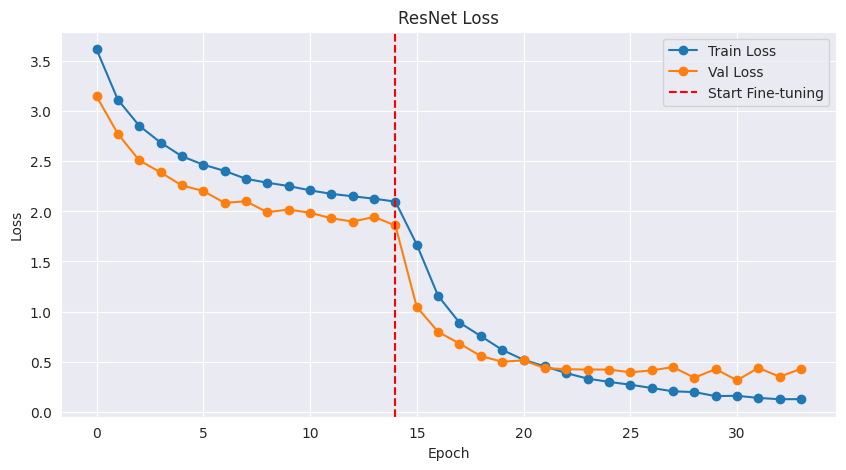

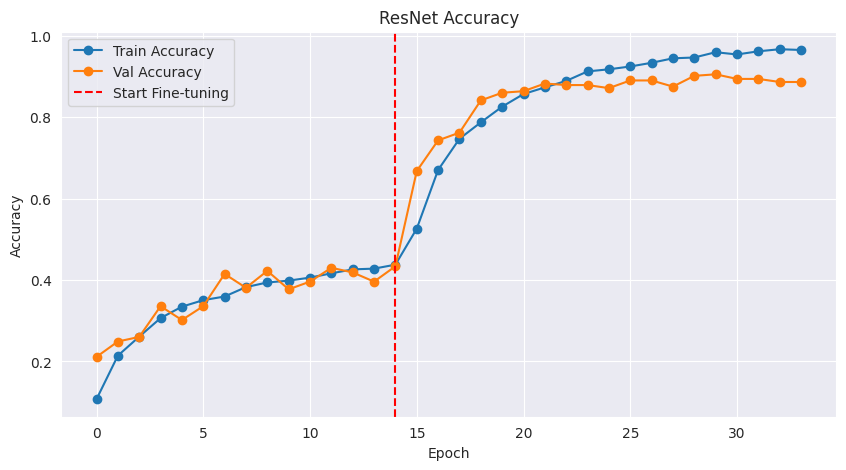

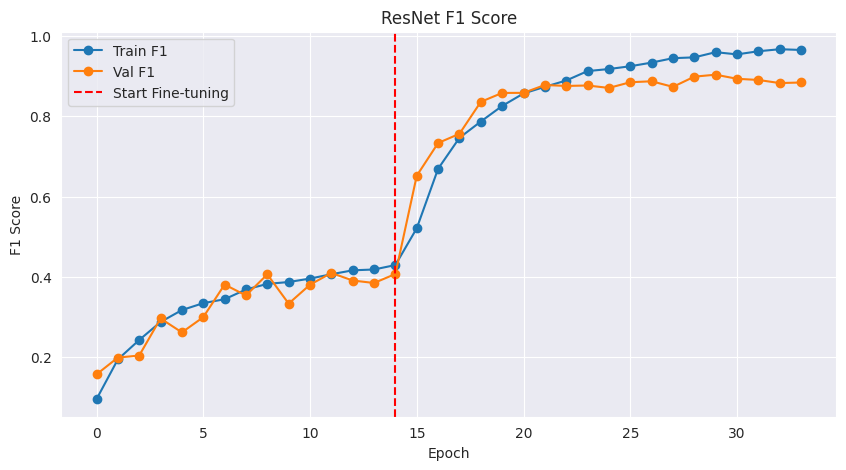

In [30]:
fine_tune_epoch = 15

plt.figure(figsize=(10,5))
plt.plot(train_loss, label='Train Loss', marker='o')
plt.plot(val_loss, label='Val Loss', marker='o')
plt.axvline(x=fine_tune_epoch-1, color='r', linestyle='--', label='Start Fine-tuning')
plt.title('ResNet Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True);

plt.figure(figsize=(10,5))
plt.plot(train_accuracy, label='Train Accuracy', marker='o')
plt.plot(val_accuracy, label='Val Accuracy', marker='o')
plt.axvline(x=fine_tune_epoch-1, color='r', linestyle='--', label='Start Fine-tuning')
plt.title('ResNet Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True);

plt.figure(figsize=(10,5))
plt.plot(train_f1_resnet, label='Train F1', marker='o')
plt.plot(val_f1_resnet, label='Val F1', marker='o')
plt.axvline(x=fine_tune_epoch-1, color='r', linestyle='--', label='Start Fine-tuning')
plt.title('ResNet F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True);